## importing libraries 

In [2]:
import os  # Import the os module for file and directory operations
import pandas as pd  # Import the pandas library for data manipulation
import numpy as np  # Import the numpy library for numerical operations
import seaborn as sns  # Import the seaborn library for statistical data visualization
import matplotlib.pyplot as plt  # Import the pyplot module from matplotlib for creating static, animated, and interactive visualizations
import warnings 
warnings.filterwarnings('ignore')


## getting a list of names of files 

The code is presented within triple backticks (```) to indicate a code block.
Comments are added above each logical section of the code to explain its purpose.
The function definition is documented using docstrings, providing information about the function's purpose, arguments, and return value.

In [3]:
def process_directory(directory):
    """
    Process a directory and return a list of Excel files within it.

    Args:
    - directory (str): The path of the directory to process.

    Returns:
    - excel_files (list): A list of Excel file names found in the directory.
    """
    # Get a list of all files in the directory
    files = os.listdir(directory)

    # Filter the list to include only Excel files
    excel_files = [file for file in files if file.endswith('.xls') or file.endswith('.xlsx')]
    
    return excel_files


## read excel files

The function read_data is defined to read data from an Excel file and return it as a DataFrame.
Docstrings are used to document the purpose of the function, its arguments, and its return value.
A comment is provided to explain the step of reading the Excel file and initializing the DataFrame.

In [4]:
def read_data(directory, file):
    """
    Read data from an Excel file and return a DataFrame.

    Args:
    - directory (str): The directory where the Excel file is located.
    - file (str): The name of the Excel file to read.

    Returns:
    - df (DataFrame): The DataFrame containing the data from the Excel file.
    """
    # Read the Excel file to initialize the DataFrame
    df = pd.read_excel(os.path.join(directory, file))
    
    return df


## filtering the data of hospitals and their dates 

The function extract_filtered_data takes a DataFrame df, a date string, and a mode integer as inputs and returns a DataFrame containing filtered data.
Docstrings are used to document the purpose of the function, its arguments, and its return value.
Comments are added to explain the conditional extraction of data based on the mode parameter and the filtering of data based on a specific condition.
A list of dates corresponding to the filtered data is created and added as a new column to the DataFrame.

In [5]:
def extract_filtered_data(df, date, mode):
    """
    Extract filtered data from a DataFrame based on a condition.

    Args:
    - df (DataFrame): The DataFrame containing the data.
    - date (str): The date associated with the data.
    - mode (int): The mode of extraction. If 1, include the last column; otherwise, exclude it.

    Returns:
    - filtered_data (DataFrame): The DataFrame containing the filtered data.
    """
    # Extract data based on condition 
    if mode == 1:
        data = df.iloc[17:, 1:]  # Adjust column slicing here
    else:
        data = df.iloc[17:, 1:-1]

    # Filter data based on a specific condition (contains 'Bristol' in 'Unnamed: 3' column)
    filtered_data = data[data['Unnamed: 3'].str.contains('Bristol', case=False, na=False)]

    # Create a list of dates corresponding to the filtered data
    dates = [date] * filtered_data.shape[0]
    filtered_data['dates'] = dates

    return filtered_data



## extracting and adding data headers from each data 

The function process_df takes a DataFrame data as input and returns a processed DataFrame.
Docstrings are used to document the purpose of the function, its arguments, and its return value.
Comments are added to explain each step of the processing:
Extracting header rows.
Modifying header1 and combining it with header2.
Removing header rows from the DataFrame.
Setting the processed headers to the DataFrame columns.
Finally, the index is reset, and the old index column is removed from the processed DataFrame.

In [6]:
def process_df(data):
    """
    Process the DataFrame by modifying headers and removing header rows.

    Args:
    - data (DataFrame): The DataFrame to be processed.

    Returns:
    - processed_data (DataFrame): The processed DataFrame.
    """
    # Extract header rows
    header1 = list(data.iloc[0, :])
    header2 = list(data.iloc[1, :])

    # Process header1
    temp_value = np.nan
    for i in range(len(header1)-1):
        if not pd.isna(header1[i]):
            temp_value = header1[i]
        else:
            header1[i] = temp_value

    # Combine header1 and header2
    for i in range(len(header2)):
        if not pd.isna(header1[i]):
            header2[i] = header1[i] + ' ' + header2[i]

    # Remove header rows from data
    data = data.iloc[2:, :]

    # Set the processed headers to the DataFrame columns
    data.columns = header2

    # Reset index and remove the old index column
    processed_data = data.reset_index().iloc[:, 1:]

    return processed_data


## procecing and combinging all functions from pervious steps 

The function process_excel_files takes a directory path directory and a processing mode mode as inputs and returns a processed DataFrame.
Docstrings are used to document the purpose of the function, its arguments, and its return value.
Comments are added to explain each step of the processing:
Reading the first Excel file and extracting data.
Iterating over subsequent Excel files, extracting data, and concatenating with the existing DataFrame.
Extracting header information and adjusting column names based on the mode.
Concatenating header and data, and processing the resulting DataFrame.

In [11]:
def process_excel_files(directory, mode):
    """
    Process Excel files from a directory based on a given mode.

    Args:
    - directory (str): The directory containing Excel files.
    - mode (int): The mode of processing.

    Returns:
    - data (DataFrame): The processed DataFrame.
    """
    # Read the first Excel file to initialize the DataFrame
    excel_files = process_directory(directory)
    temp_df = read_data(directory, excel_files[0])

    # Extract data based on condition for the first file
    date = excel_files[0].replace(".xls", "")
    temp_df = extract_filtered_data(temp_df, date, mode)
    
    # Adjust column names if mode is 3
    if mode == 3:
        temp_df.columns = [i for i in range(len(temp_df.columns))]

    # Iterate over each subsequent Excel file
    for file in excel_files[1:]:
        df = read_data(directory, file)
        
        date = file.replace(".xls", "")

        filtered_data = extract_filtered_data(df, date, mode)
        
        # Adjust column names if mode is 3
        if mode == 3:
            filtered_data.columns = [i for i in range(len(filtered_data.columns))]
        
        temp_df = pd.concat([temp_df, filtered_data], axis=0)

    # Extract header information
    if mode == 1:
        header = df.iloc[13:15, 1:]
        header['dates'] = [np.nan, 'dates']
        temp_df = temp_df.iloc[:, :-1]
    else:
        header = df.iloc[13:15, 1:-1]
        header['dates'] = [np.nan, 'dates']
        
    # Adjust column names if mode is 3
    if mode == 3:
        header.columns = [i for i in range(len(header.columns))]

    # Concatenate header and data, and process DataFrame
    concatenated_data = pd.concat([header, temp_df], axis=0)
    data = process_df(concatenated_data)
    
    date_column = list(data['dates'])

    month_dict = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }
    new_dates = []
    
    for i in range(len(date_column)):
        
        parts = date_column[i].split('-')
        
        new_date = parts[1] + '/' + month_dict[parts[0]]
        
        new_dates.append(new_date)

    data.drop('dates', axis=1, inplace=True)  # Drop the original column
    
    data['dates'] = pd.to_datetime(new_dates, format='%Y/%m')

    return data

## merging the all three files and doing data cleaning 


Data for different time periods (2015-2017, 2017-2018, and 2018-2024) is processed separately.
Columns deemed unnecessary are dropped from the datasets data_2018_2024 and data_2017_2018.
The datasets data_2015_2017 and data_2015_2017 are concatenated with additional columns added to data_2015_2017.
Column names of data_2015_2017 are adjusted to match those of data_2017_2024.
The final dataset data_2015_2024 is formed by concatenating data_2017_2024 and data_2015_2017.
The resulting dataset is saved as a CSV file.

In [12]:
# For processing data from 2015 to 2017
file_path = "2015-2017"
data_2015_2017 = process_excel_files(file_path, 1)

# For processing data from 2018 to 2024
file_path = "2018-2024"
data_2018_2024 = process_excel_files(file_path, 3)

# For processing data from 2017 to 2018
file_path = "2017-2018"
data_2017_2018 = process_excel_files(file_path, 2)

# Dropping columns from data_2018_2024
columns_to_drop = ['Percentage of attendances within 4 hours Percentage in 4 hours or less (all)',
                   'Percentage of attendances within 4 hours Percentage in 4 hours or less (type 1)',
                   'Percentage of attendances within 4 hours Percentage in 4 hours or less (type 2)',
                   'Percentage of attendances within 4 hours Percentage in 4 hours or less (type 3)']
data_2018_2024 = data_2018_2024.drop(columns=columns_to_drop)

# Dropping columns from data_2017_2018
columns_to_drop = ['Percentage of attendances within 4 hours Percentage in 4 hours or less (type 1)',
                   'Percentage of attendances within 4 hours Percentage in 4 hours or less (all)']
data_2017_2018 = data_2017_2018.drop(columns=columns_to_drop)

# Concatenating data_2018_2024 and data_2017_2018
data_2017_2024 = pd.concat([data_2018_2024, data_2017_2018])

# Creating new columns for data_2015_2017
New_Column1 = data_2015_2017['A&E attendances Type 1 Departments - Major A&E'].astype(float) - data_2015_2017['A&E attendances > 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E'].astype(float)
New_Column2 = data_2015_2017['A&E attendances Type 2 Departments - Single Specialty'].astype(float) - data_2015_2017['A&E attendances > 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty'].astype(float)
New_Column3 = data_2015_2017['A&E attendances Type 3 Departments - Other A&E/Minor Injury Unit'].astype(float) - data_2015_2017['A&E attendances > 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit'].astype(float)
New_Column4 = data_2015_2017['A&E attendances Total attendances'].astype(float) - data_2015_2017['A&E attendances > 4 hours from arrival to admission, transfer or discharge Total Attendances > 4 hours'].astype(float)

# Inserting new columns to data_2015_2017
data_2015_2017.insert(loc=7, column='A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E', value=New_Column1)
data_2015_2017.insert(loc=8, column='A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty', value=New_Column2)
data_2015_2017.insert(loc=9, column='A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit', value=New_Column3)
data_2015_2017.insert(loc=10, column='A&E attendances less than 4 hours from arrival to admission, transfer or discharge Total Attendances < 4 hours', value=New_Column4)

# Dropping columns from data_2015_2017
columns_to_drop = ['A&E attendances > 4 hours from arrival to admission, transfer or discharge Percentage in 4 hours or less (type 1)',
                   'A&E attendances > 4 hours from arrival to admission, transfer or discharge Percentage in 4 hours or less (all)']
data_2015_2017 = data_2015_2017.drop(columns=columns_to_drop)

# Renaming columns of data_2015_2017 to match data_2017_2024
data_2015_2017.columns = data_2017_2024.columns

# Concatenating data_2017_2024 and data_2015_2017
data_2015_2024 = pd.concat([data_2017_2024, data_2015_2017])

# Saving the concatenated data to a CSV file
data_2015_2024.to_csv('health data bristol.csv', index=False)


In [13]:
data_2015_2024

,Code,Region,Name,A&E attendances Type 1 Departments - Major A&E,A&E attendances Type 2 Departments - Single Specialty,A&E attendances Type 3 Departments - Other A&E/Minor Injury Unit,A&E attendances Total attendances,"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E","A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty","A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit",...,"A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Total Attendances > 4 hours",Emergency Admissions Emergency Admissions via Type 1 A&E,Emergency Admissions Emergency Admissions via Type 2 A&E,Emergency Admissions Emergency Admissions via Type 3 and 4 A&E,Emergency Admissions Total Emergency Admissions via A&E,Emergency Admissions Other Emergency admissions (i.e not via A&E),Emergency Admissions Total Emergency Admissions,Emergency Admissions Number of patients spending >4 hours from decision to admit to admission,Emergency Admissions Number of patients spending >12 hours from decision to admit to admission,dates
0,NLW,NHS England South West,Bristol Community Health,0,0,4560,4560,0,0,4555,...,5,0,0,0,0,0,0,0,0,2018-04-01
1,RVJ,NHS England South West,North Bristol NHS Trust,7429,0,0,7429,6168,0,0,...,1261,2536,0,0,2536,1659,4195,373,0,2018-04-01
2,RA7,NHS England South West,University Hospitals Bristol NHS Foundation Trust,9569,2036,0,11605,7821,1922,0,...,1862,2985,9,0,2994,838,3832,396,0,2018-04-01
3,NLW,NHS England South West,Bristol Community Health,0,0,4839,4839,0,0,4832,...,7,0,0,0,0,0,0,0,0,2019-04-01
4,RVJ,NHS England South West,North Bristol NHS Trust,7934,0,0,7934,5532,0,0,...,2402,3183,0,0,3183,1772,4955,666,0,2019-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,RVJ,South Of England Commissioning Region,North Bristol NHS Trust,7049,0,0,7049,6241.0,0.0,0.0,...,808,2305,0,0,2305,1175,3480,307,0,2015-09-01
62,RA7,South Of England Commissioning Region,University Hospitals Bristol NHS Foundation Trust,8563,1768,0,10331,7708.0,1764.0,0.0,...,859,2725,13,0,2738,650,3388,293,0,2015-09-01
63,NLW,South Of England Commissioning Region,Bristol Community Health,0,0,5073,5073,0.0,0.0,4994.0,...,79,0,0,0,0,0,0,0,0,2016-09-01
64,RVJ,South Of England Commissioning Region,North Bristol NHS Trust,7329,0,0,7329,6135.0,0.0,0.0,...,1194,2598,0,0,2598,1247,3845,393,3,2016-09-01


## data visulisation and setting date 

The 'dates' column is converted to datetime format using pd.to_datetime.
'year' column is extracted from 'dates' using dt.year.
A loop iterates over each column (excluding the first 3 and last 2) to create line plots using Seaborn's lineplot function.
Inside the loop:
A new figure is created for each plot with adjusted width and height using plt.figure.
Line plot is created using Seaborn's lineplot function, specifying 'dates' as the x-axis, the current column as the y-axis, and 'Name' as the hue.
x-axis labels are rotated for better visibility using plt.xticks(rotation=90).
A title is set for each plot using ax.set_title.
The plot is displayed using plt.show().
Finally, the correlation matrix is calculated using .corr() on the selected columns

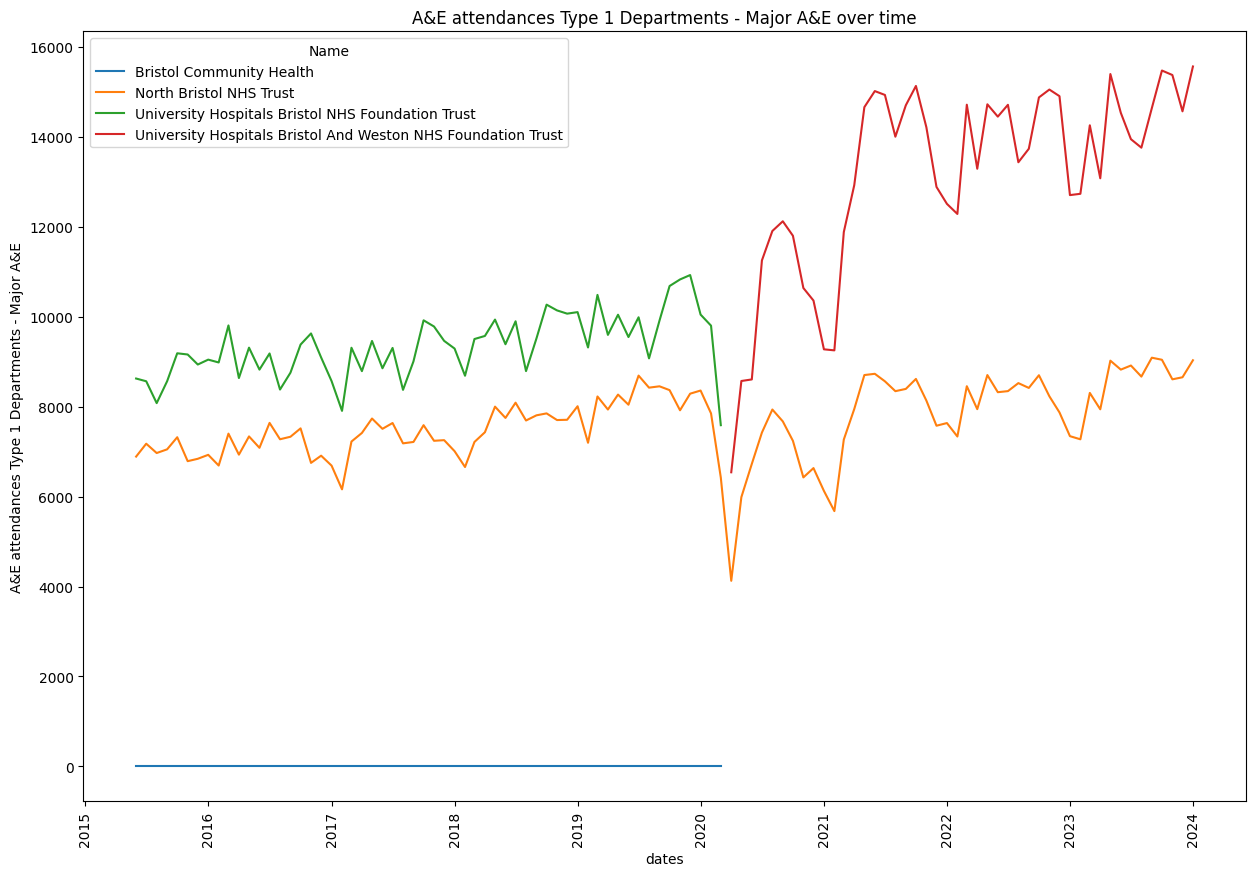

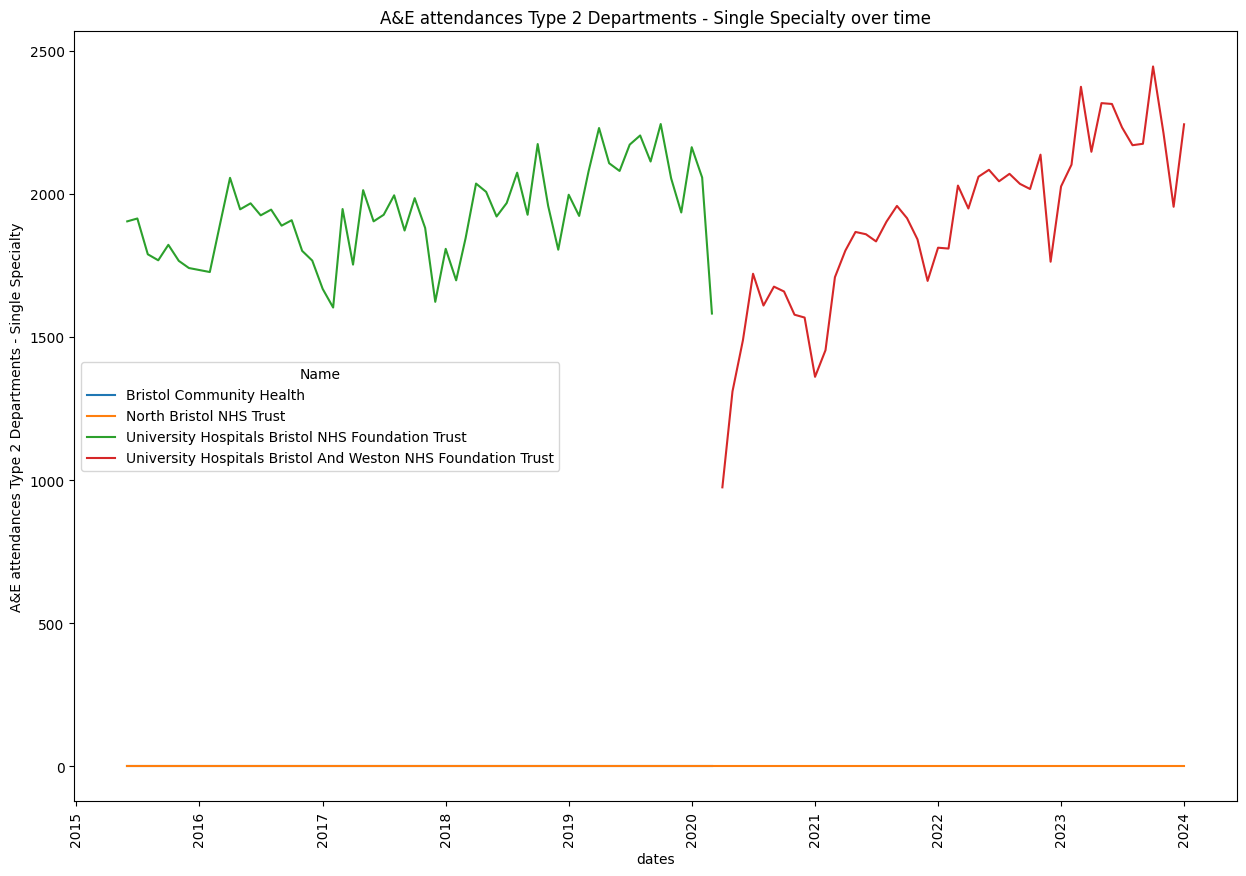

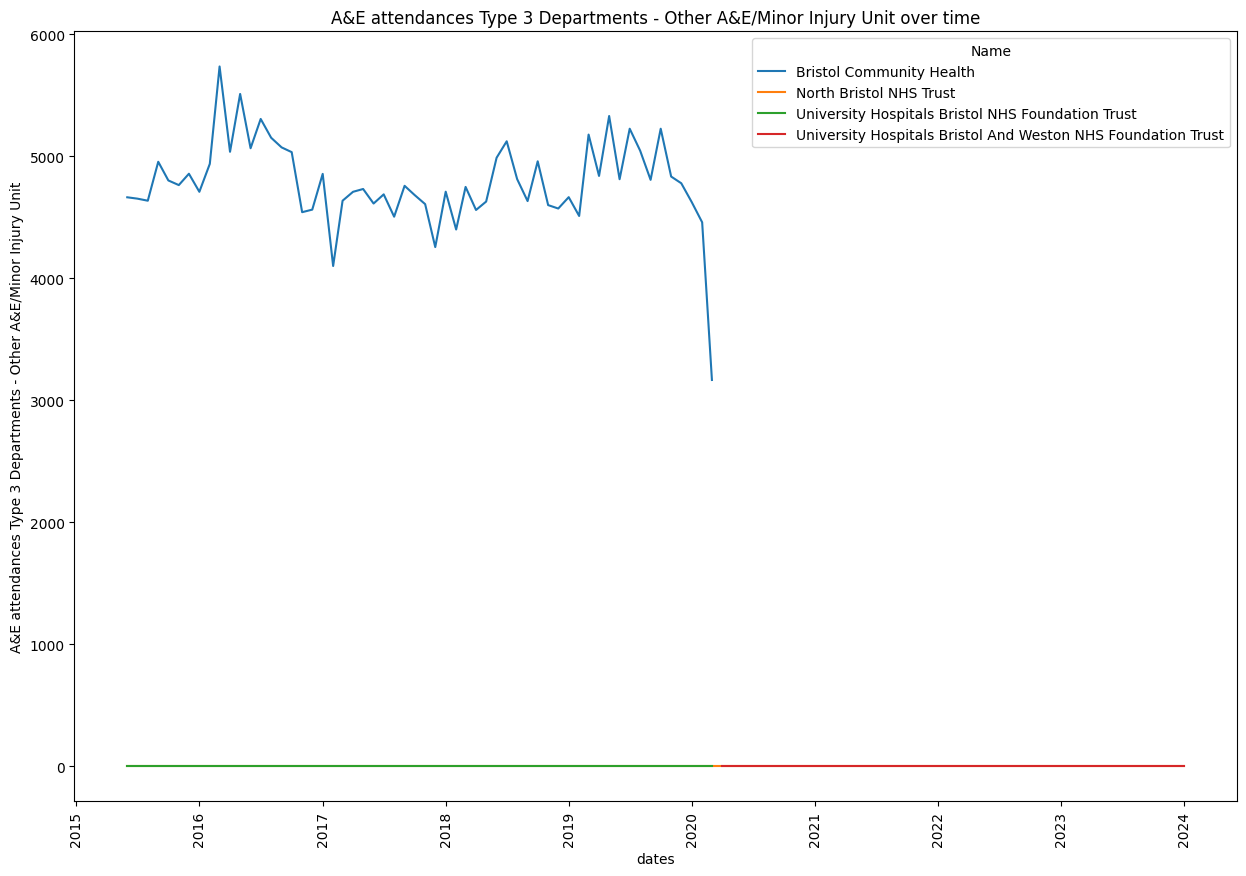

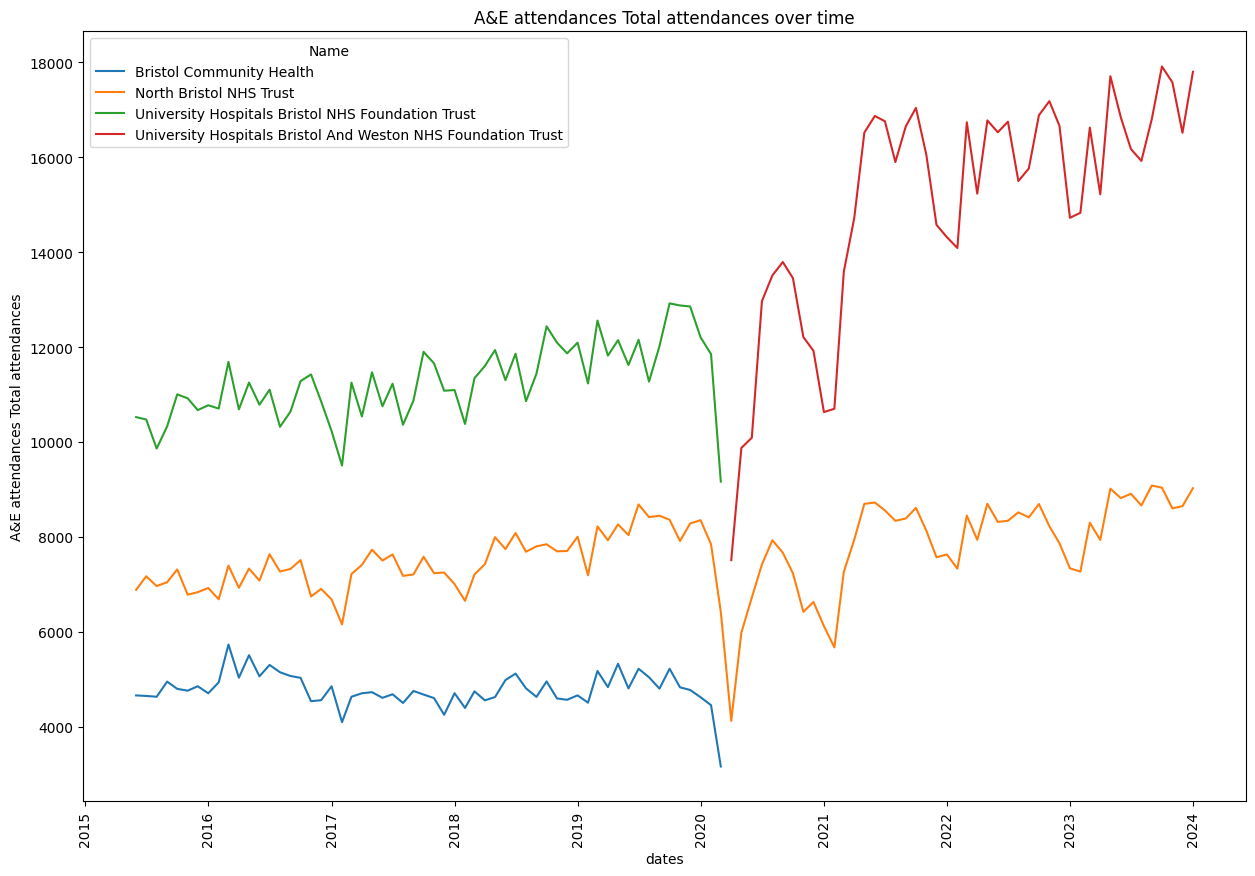

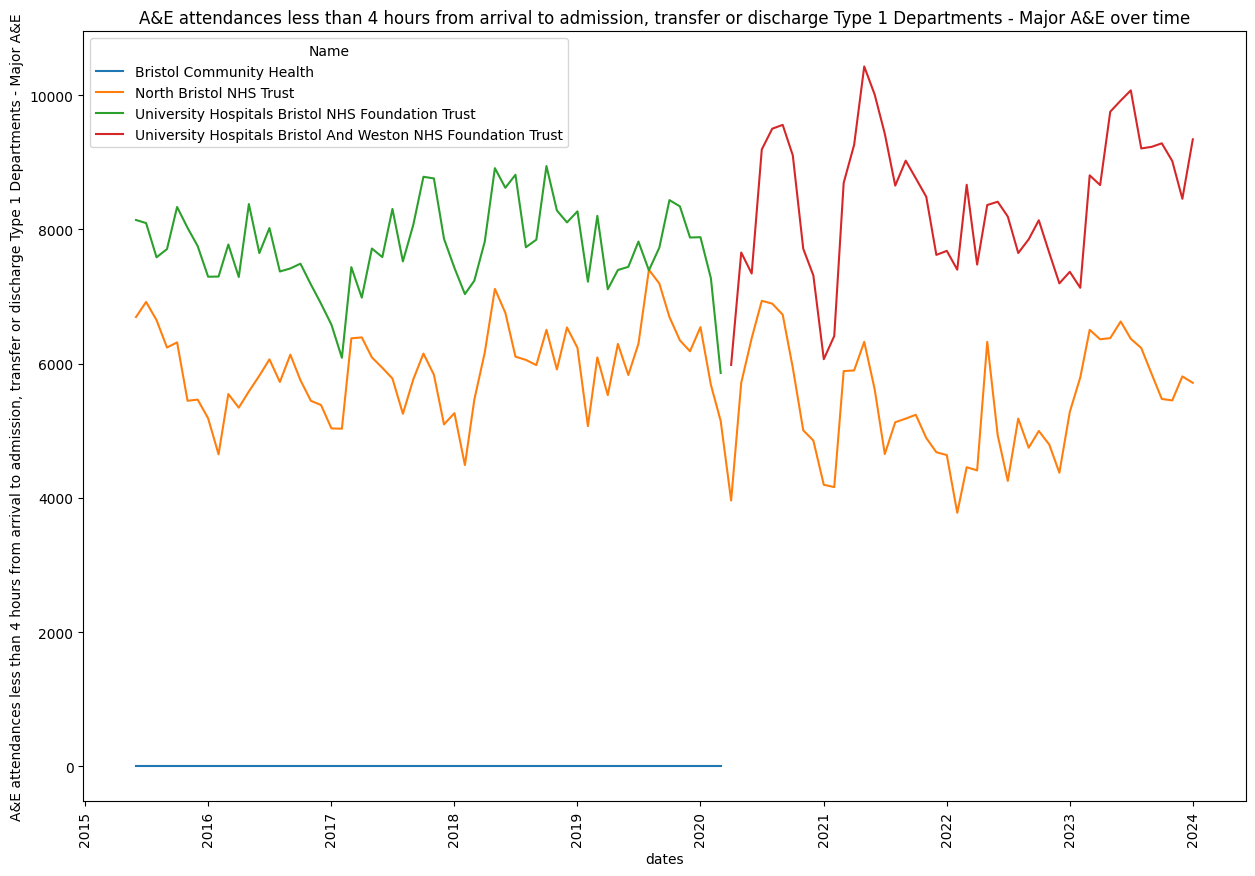

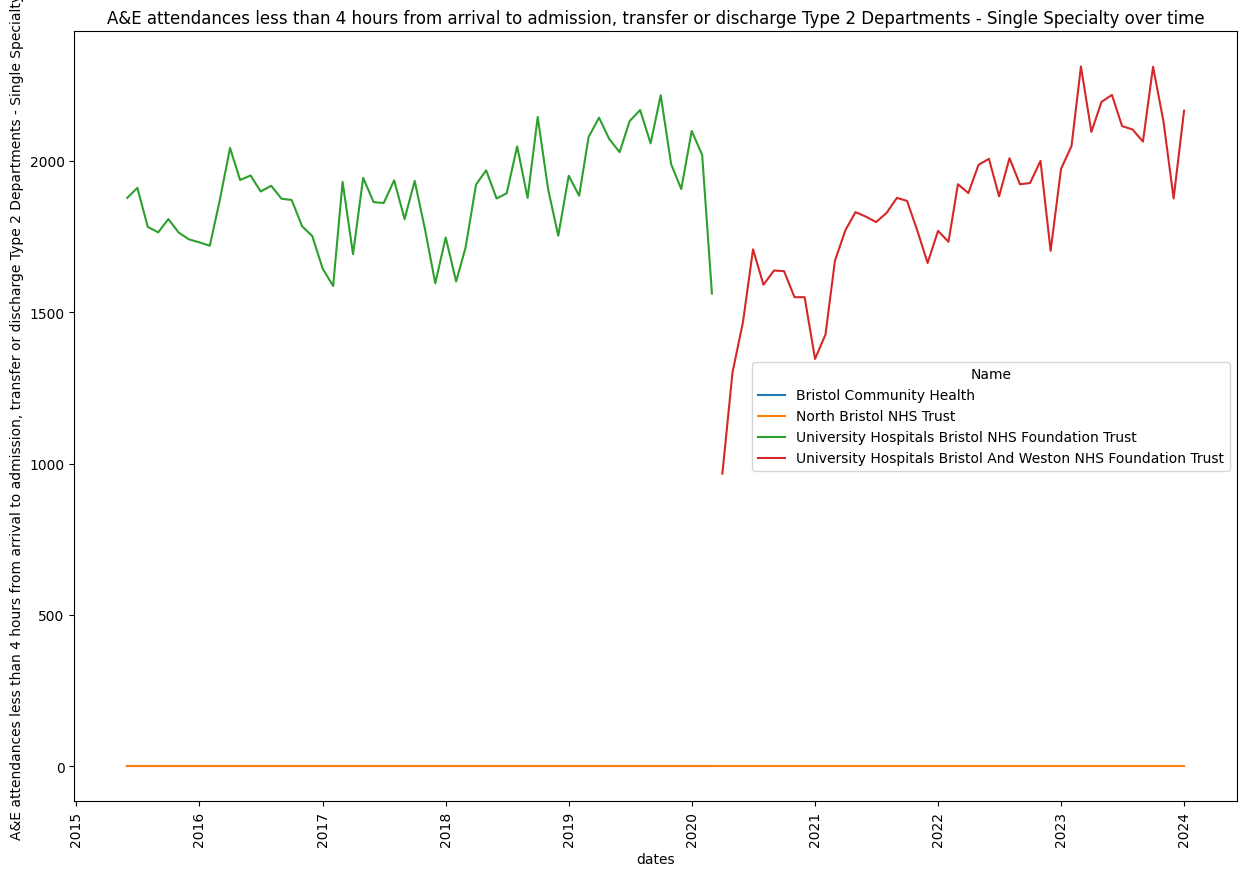

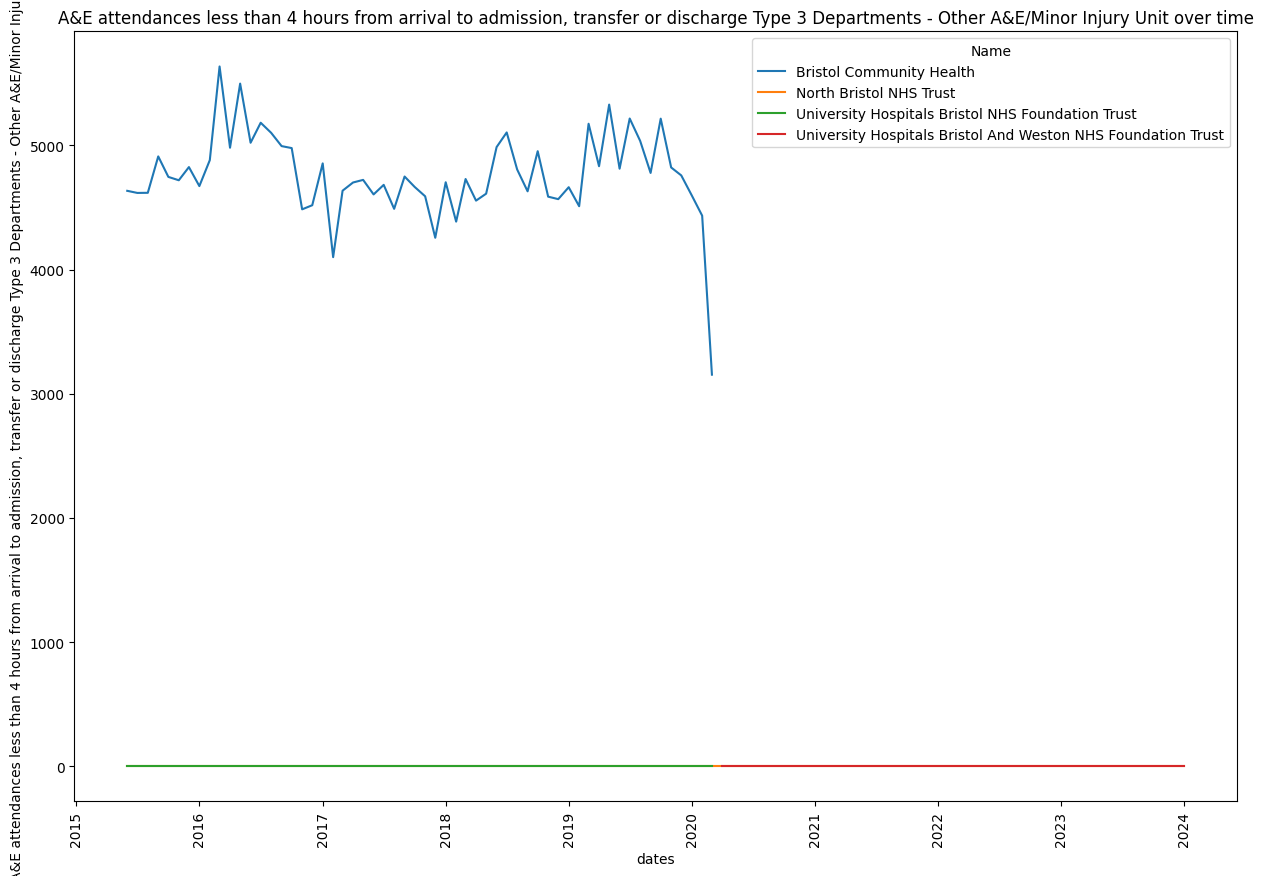

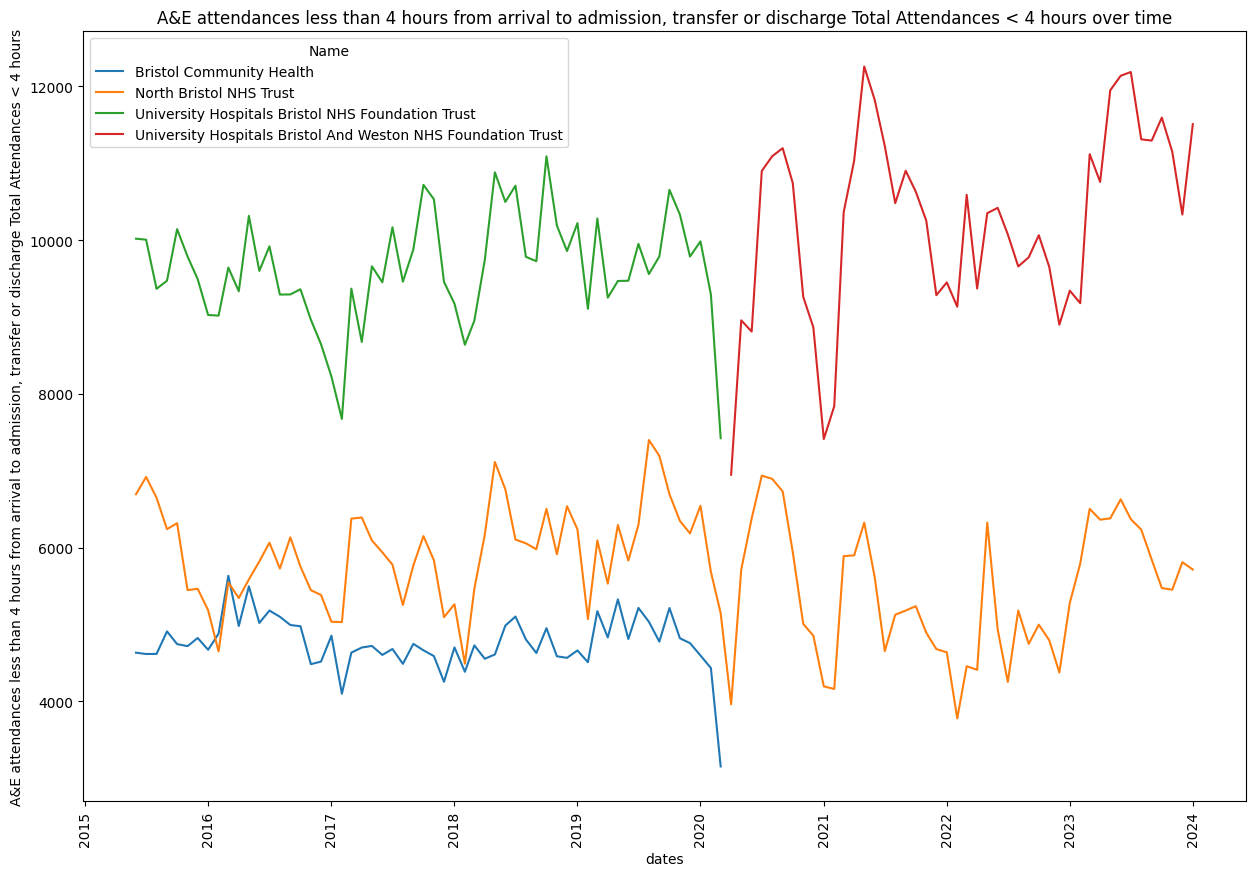

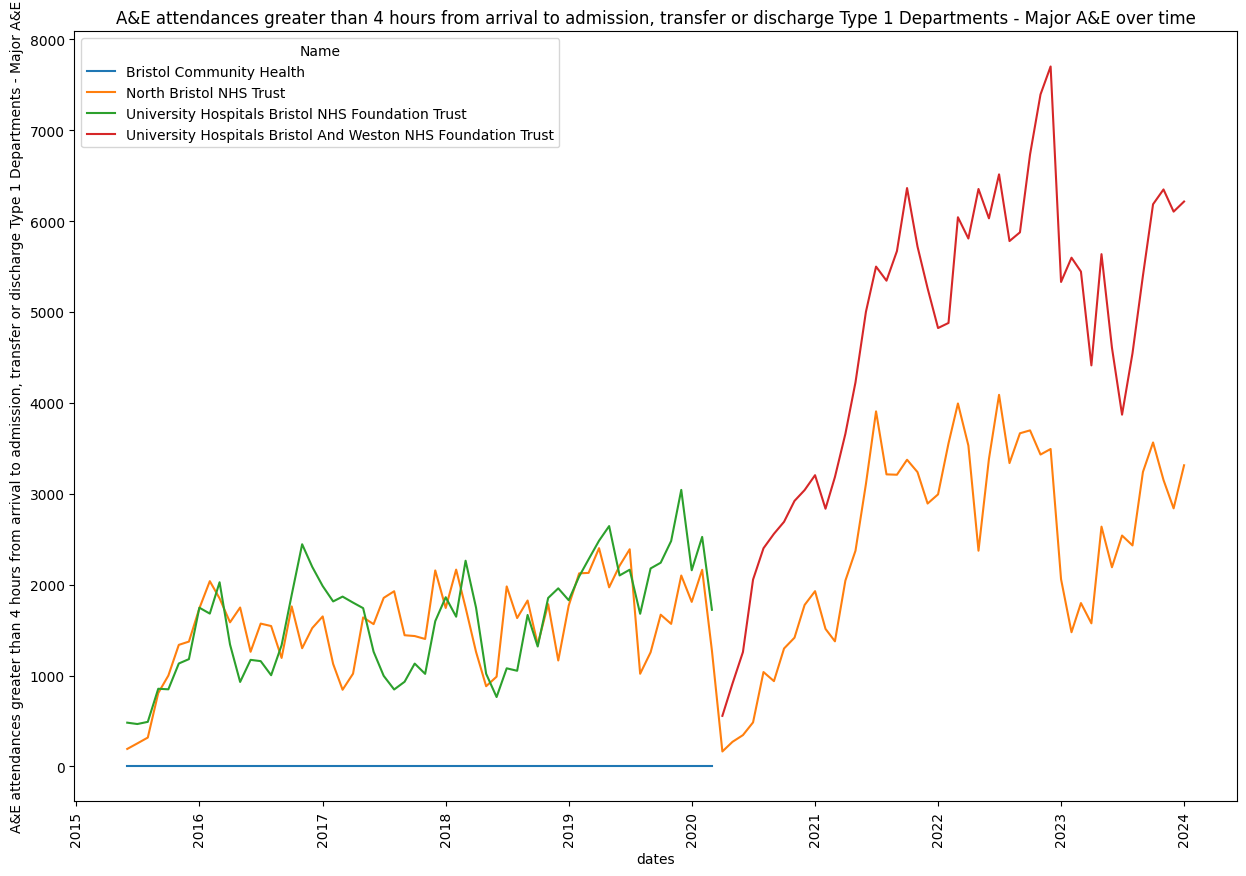

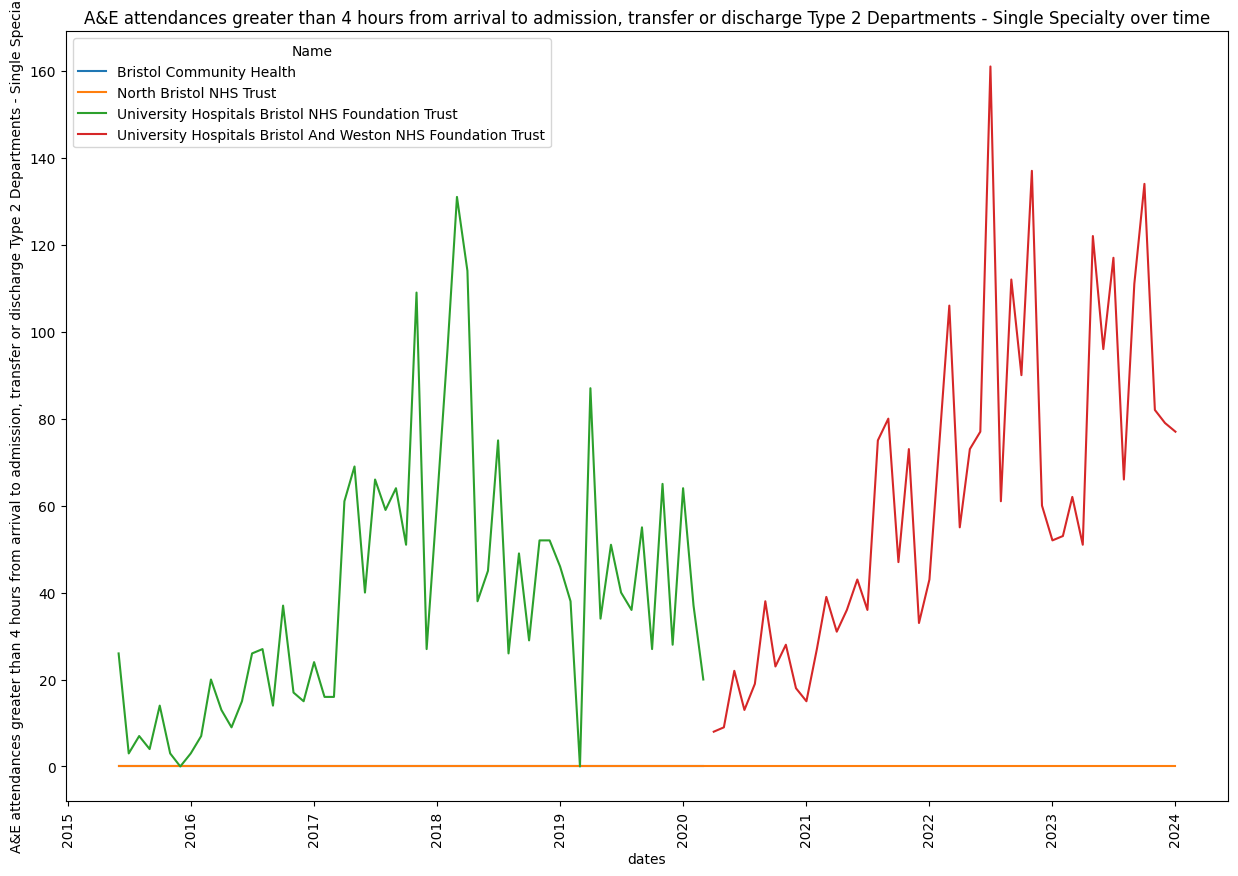

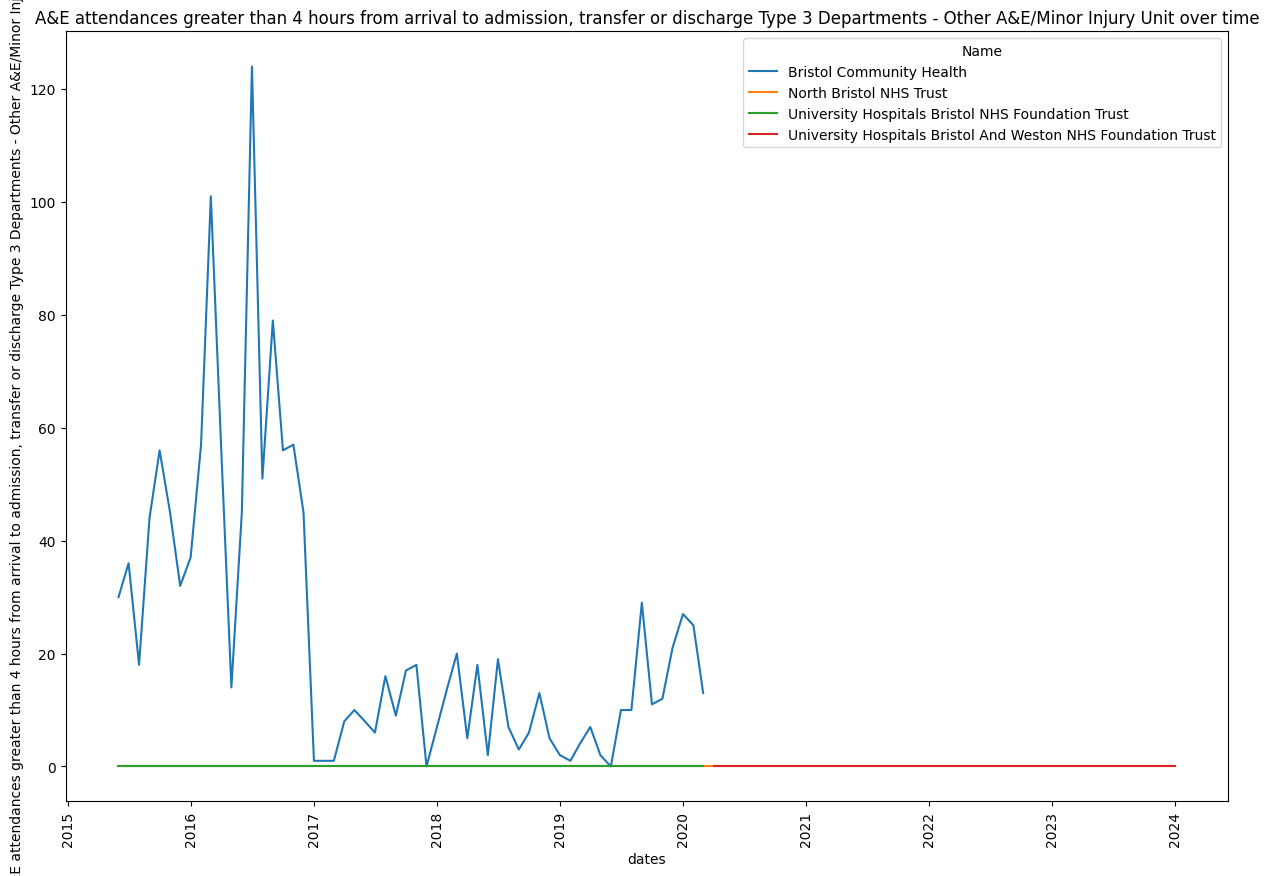

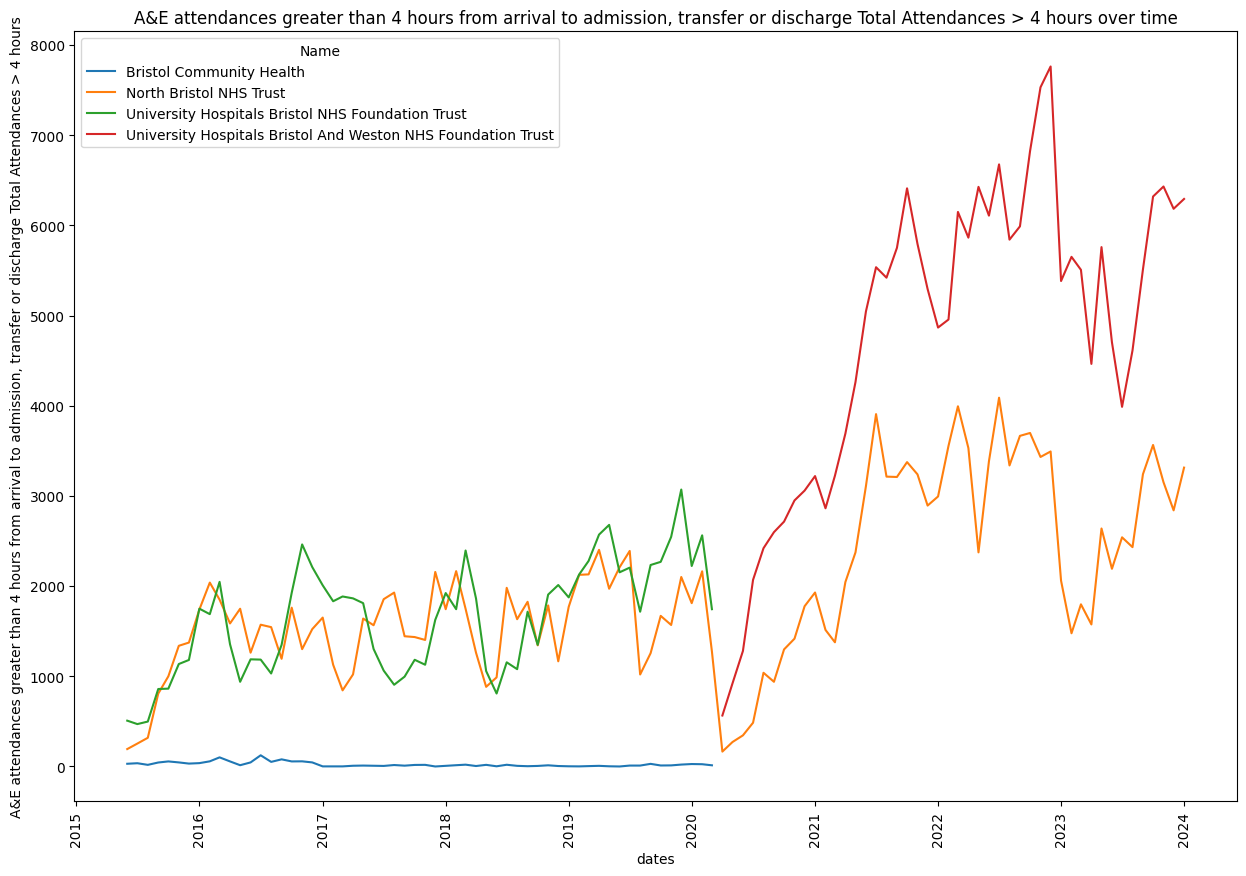

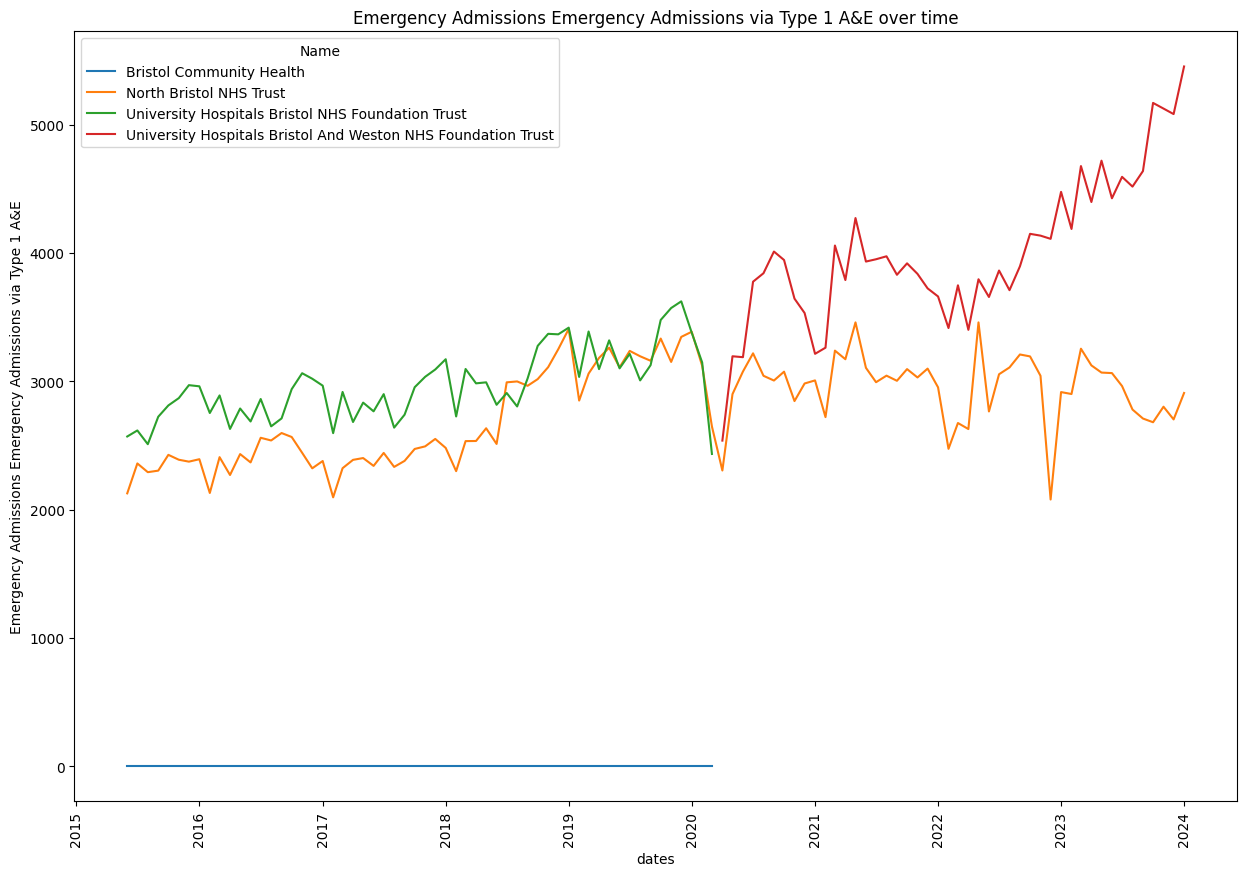

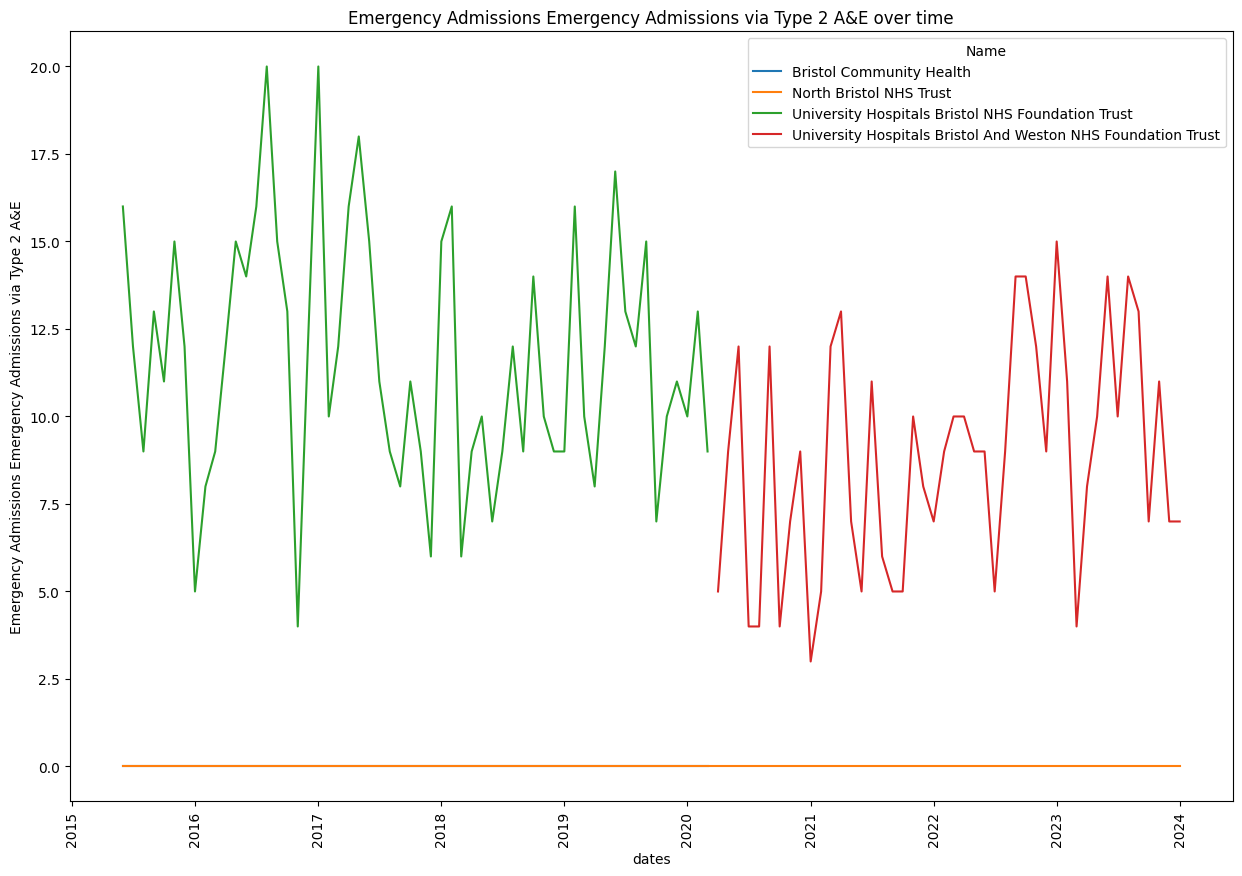

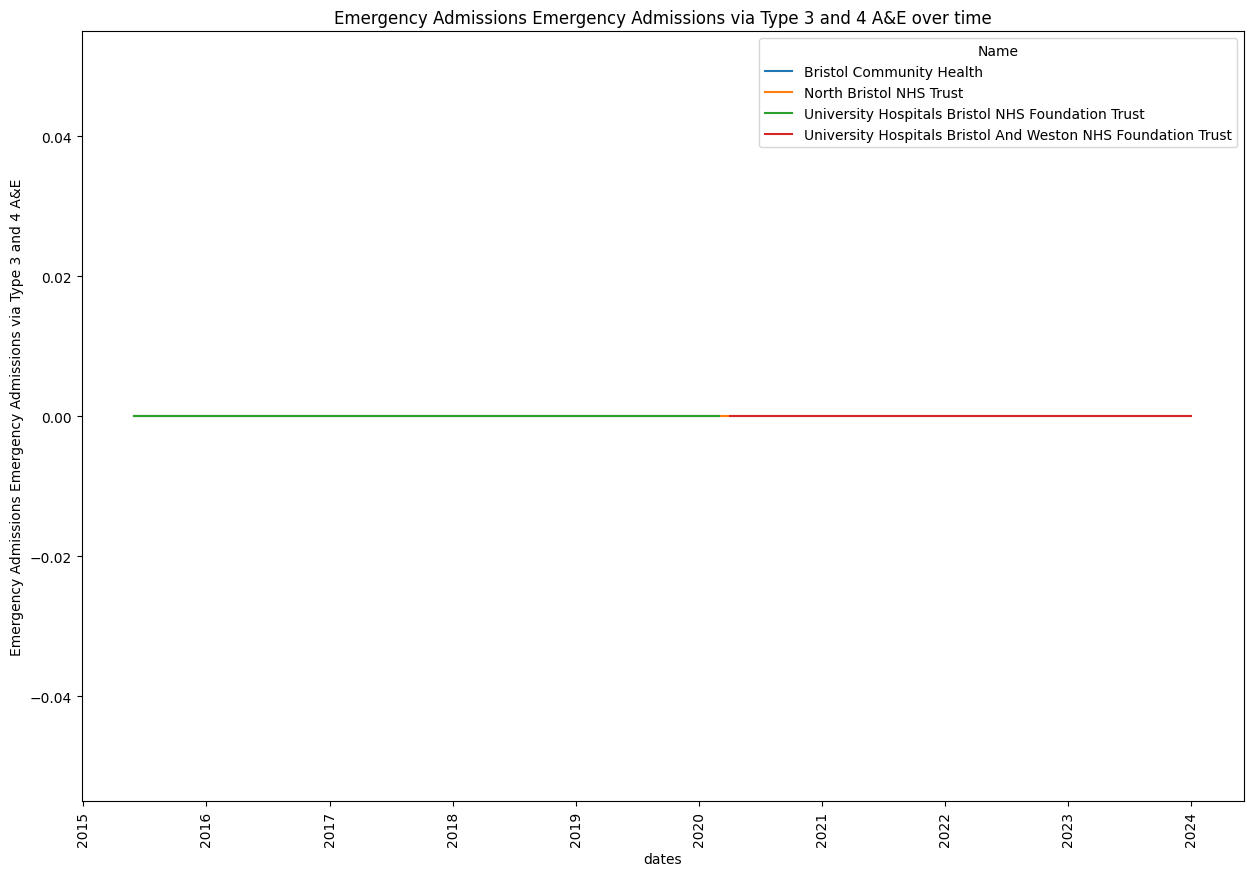

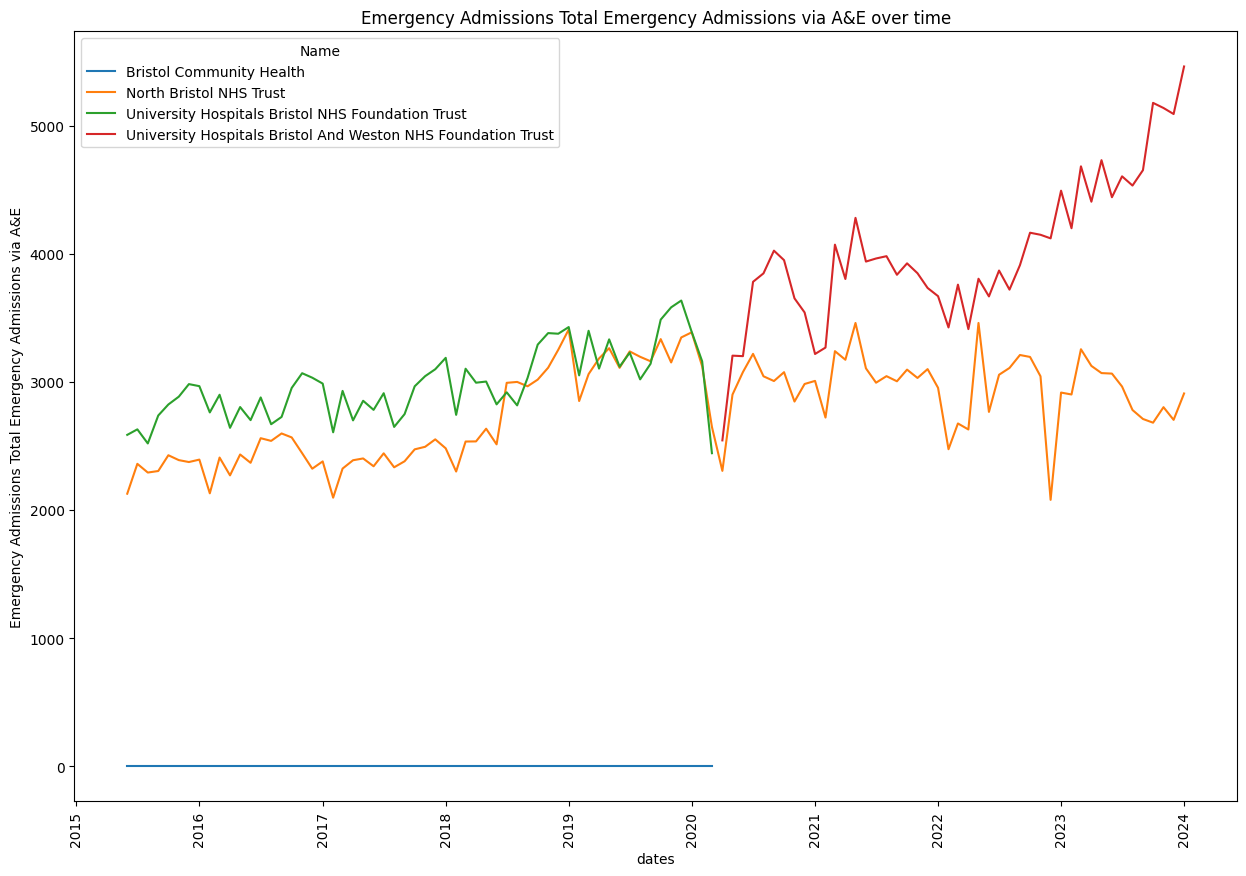

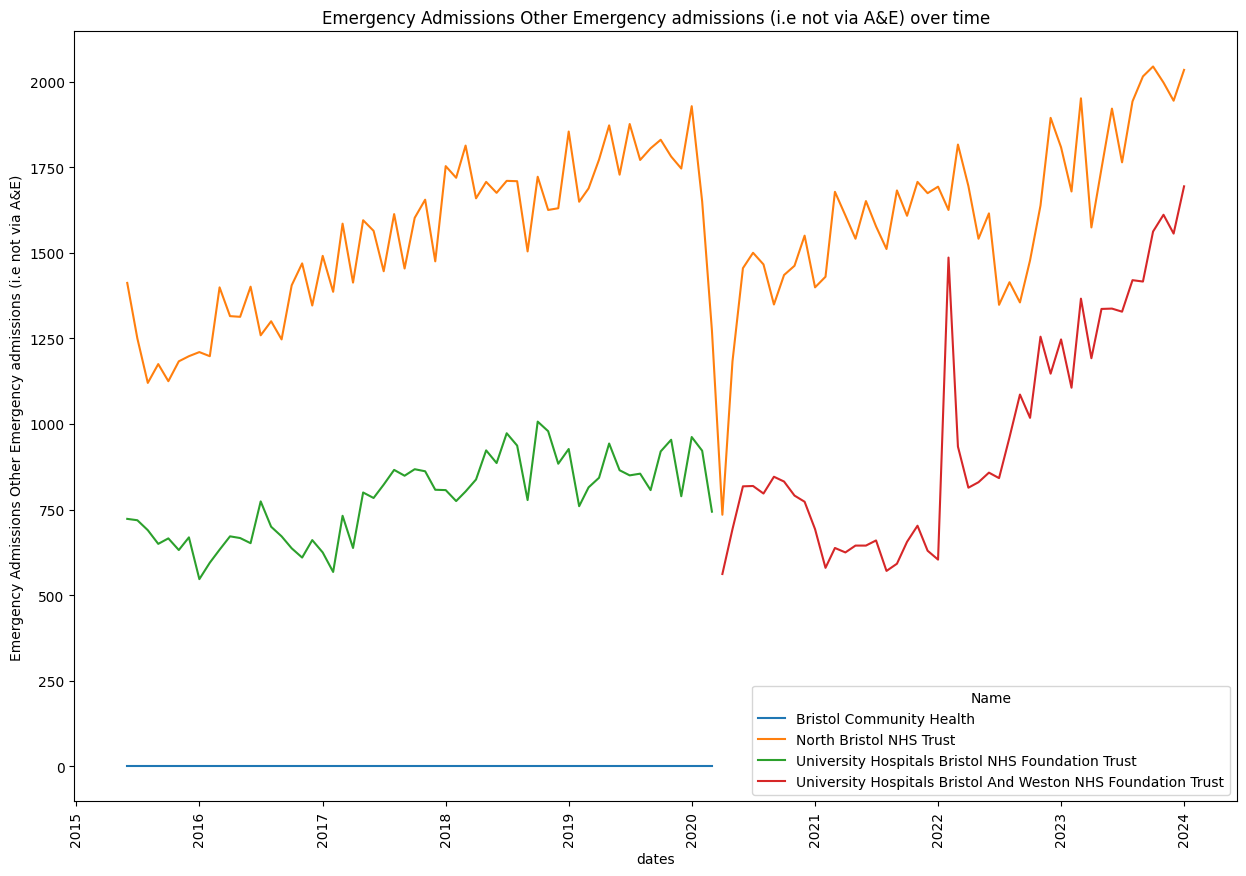

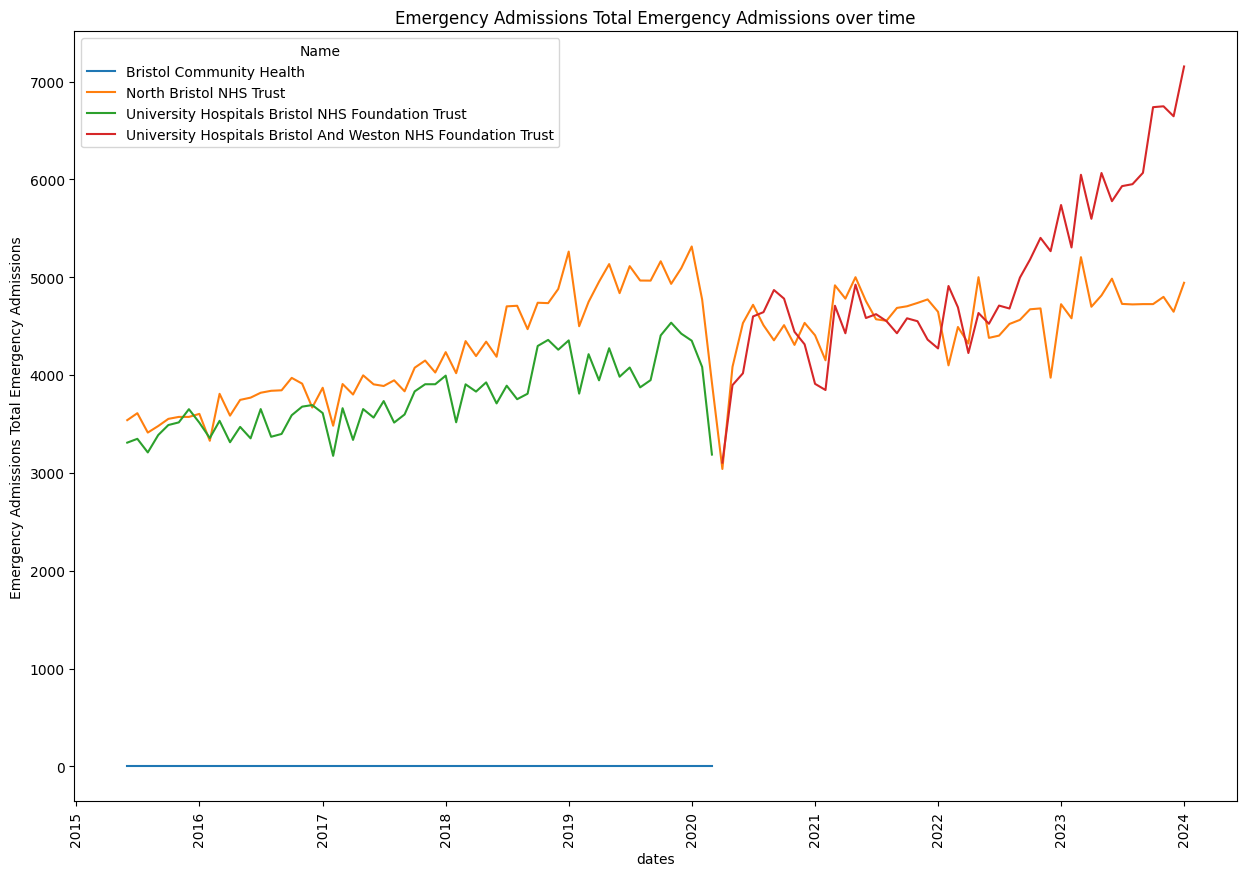

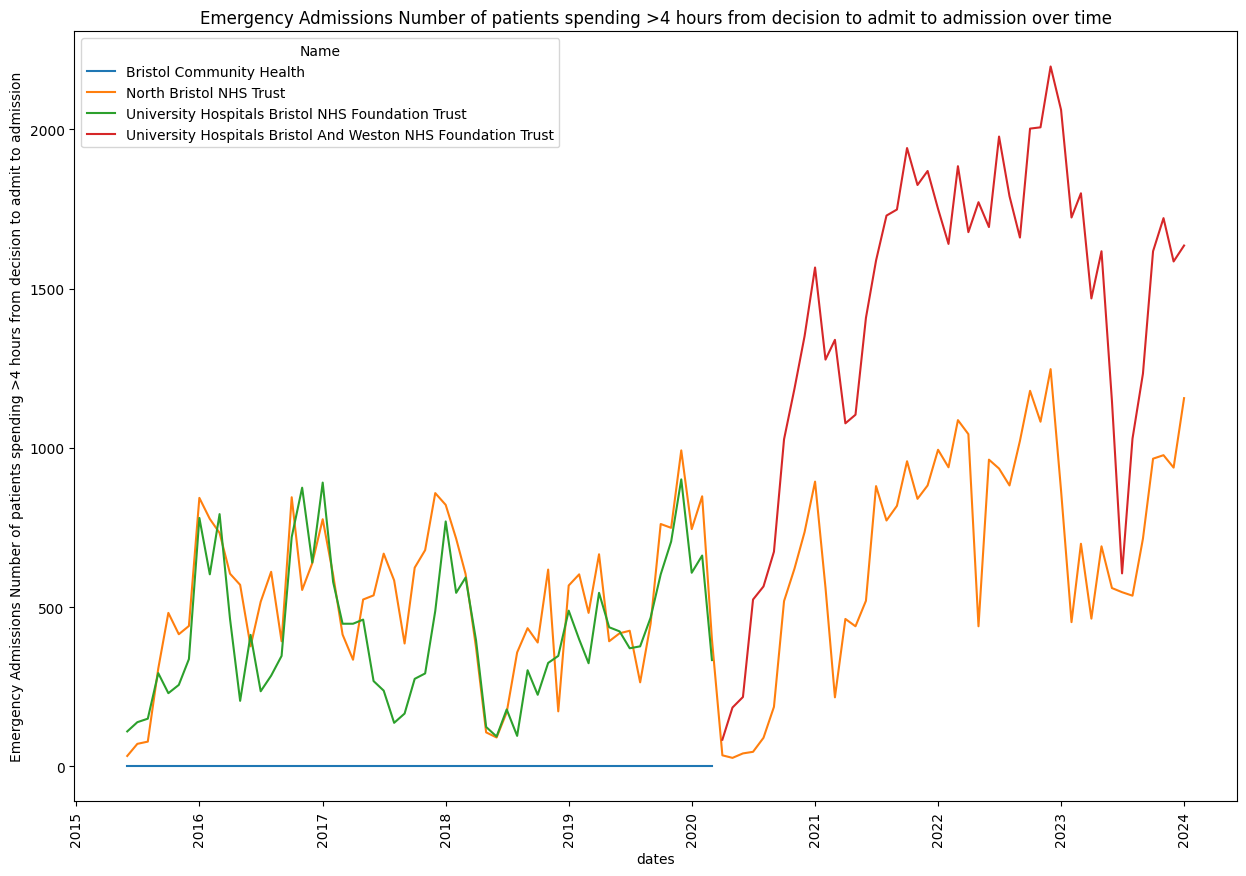

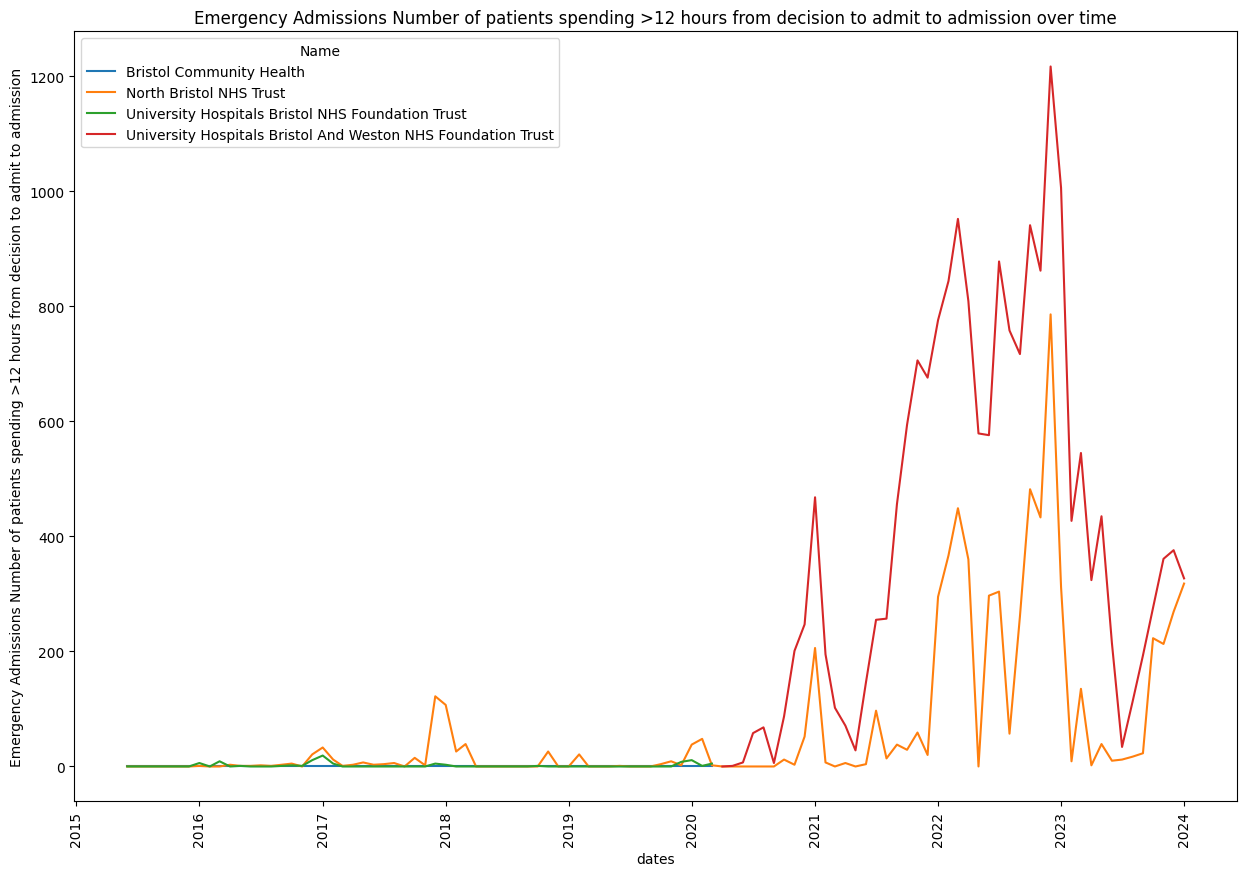

,A&E attendances Type 1 Departments - Major A&E,A&E attendances Type 2 Departments - Single Specialty,A&E attendances Type 3 Departments - Other A&E/Minor Injury Unit,A&E attendances Total attendances,"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E","A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty","A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit","A&E attendances less than 4 hours from arrival to admission, transfer or discharge Total Attendances < 4 hours","A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E","A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty","A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit","A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Total Attendances > 4 hours",Emergency Admissions Emergency Admissions via Type 1 A&E,Emergency Admissions Emergency Admissions via Type 2 A&E,Emergency Admissions Emergency Admissions via Type 3 and 4 A&E,Emergency Admissions Total Emergency Admissions via A&E,Emergency Admissions Other Emergency admissions (i.e not via A&E),Emergency Admissions Total Emergency Admissions,Emergency Admissions Number of patients spending >4 hours from decision to admit to admission,Emergency Admissions Number of patients spending >12 hours from decision to admit to admission
A&E attendances Type 1 Departments - Major A&E,1.000000,0.688076,-0.866949,0.917808,0.950618,0.684640,-0.867069,0.786301,0.837590,0.632007,-0.553663,0.837352,0.968622,0.574138,NaN,0.969032,0.592397,0.912372,0.782585,0.506022
A&E attendances Type 2 Departments - Single Specialty,0.688076,1.000000,-0.416600,0.864411,0.691032,0.999759,-0.416658,0.941963,0.511314,0.784035,-0.266055,0.519054,0.582104,0.911511,NaN,0.584597,-0.088404,0.402022,0.450109,0.335394
A&E attendances Type 3 Departments - Other A&E/Minor Injury Unit,-0.866949,-0.416600,1.000000,-0.615067,-0.909271,-0.417018,0.999983,-0.519207,-0.576296,-0.311971,0.658657,-0.571498,-0.914913,-0.383448,NaN,-0.914671,-0.793519,-0.939201,-0.554527,-0.235925
A&E attendances Total attendances,0.917808,0.864411,-0.615067,1.000000,0.835976,0.859968,-0.615237,0.912772,0.833009,0.797545,-0.381979,0.837309,0.826640,0.721762,NaN,0.827910,0.264615,0.699106,0.762499,0.570752
"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E",0.950618,0.691032,-0.909271,0.835976,1.000000,0.690685,-0.909397,0.818009,0.626677,0.546914,-0.580691,0.626417,0.943526,0.612042,NaN,0.944135,0.586030,0.891877,0.573948,0.273178
"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 2 Departments - Single Specialty",0.684640,0.999759,-0.417018,0.859968,0.690685,1.000000,-0.417076,0.941257,0.503297,0.770228,-0.266322,0.510850,0.579564,0.913351,NaN,0.582070,-0.091339,0.399179,0.443190,0.327112
"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Type 3 Departments - Other A&E/Minor Injury Unit",-0.867069,-0.416658,0.999983,-0.615237,-0.909397,-0.417076,1.000000,-0.519380,-0.576376,-0.312014,0.654242,-0.571616,-0.915040,-0.383501,NaN,-0.914798,-0.793629,-0.939331,-0.554604,-0.235958
"A&E attendances less than 4 hours from arrival to admission, transfer or discharge Total Attendances < 4 hours",0.786301,0.941963,-0.519207,0.912772,0.818009,0.941257,-0.519380,1.000000,0.534440,0.752088,-0.318661,0.540951,0.696841,0.833066,NaN,0.698802,0.072371,0.539827,0.460511,0.287163
"A&E attendances greater than 4 hours from arrival to admission, transfer or discharge Type 1 Departments - Major A&E",0.837590,0.511314,-0.5

In [14]:
data=data_2015_2024

# Convert 'dates' column to datetime format
data['dates'] = pd.to_datetime(data['dates'], format='%B-%Y')

# Extract 'year' from 'dates'
data['year'] = data['dates'].dt.year

# Iterate over each column (excluding first 3 and last 2) to create line plots
for column in data.columns[3:-2]:
    # Create a new figure for each plot with adjusted width and height
    plt.figure(figsize=(15, 10))

    # Create line plot using Seaborn's lineplot function
    ax = sns.lineplot(data=data, x='dates', y=column, hue='Name')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)

    # Set title for the plot
    ax.set_title(column + ' over time')

    # Show the plot
    plt.show()

# Convert selected columns to numeric data type, replacing non-convertible values with NaN
data = data.iloc[:, 3:-2].apply(pd.to_numeric, errors='coerce')


# Calculate correlation matrix for the converted numeric columns
correlation_matrix = data.corr()

correlation_matrix